In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
# from collections import OrderedDict
%matplotlib inline

import torchvision.transforms as transforms

In [2]:
# 계층적인 폴더 구조를 갖고 있는 데이터셋을 불러올때 사용 : 폴더 이름 = 클래스 명
from torchvision.datasets import ImageFolder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# another
dataset = ImageFolder('data/Images')

test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# custom Dataset
class DogData(Dataset) :
    def __init__(self, ds, transform = None) :
        self.ds = ds
        self.transform = transform
    
    def __len__(self) :
        return len(self.ds)
    
    def __getitem__(self, idx) :
        img, label = self.ds[idx]
        if self.transform :
            img = self.transform(img)
            return img, label

        
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]) 
                                      ])

val_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train = DogData(train, train_transforms)
val = DogData(val, val_transforms)
test = DogData(test, test_transforms)


num_workers = 4
batch_size = 64

trainLoader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
valLoader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
testLoader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)

In [5]:
# 13 + 3 =vgg16
#  cfgs = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }


# cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] 
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

In [6]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=120, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution layer : make layers로 생성
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) #이미지가 7 by 7보다 작을경우에는 안 사용해도됨 
        
        # classifier : fully connected layer 
        self.classifier = nn.Sequential(
            # 32 32 -> 16 8 "4" (maxpooling 3번 거치기 때문) 224 224 -> 112 56 28
            nn.Linear(512 * 7 * 7, 4096), # custom시 이미지 사이즈가 다를경우 꼭 수정을 해줘야함(연산수가 달라질경우)
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) 
        x = self.classifier(x) #FC layer
        return x
    
    # 층의 특성에 맞게 weight initialize
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # m이 conv2d일때 kaiming_normal로 초기화
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:   # VGG에서는 bias값이 0
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)

# 'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

# make_layers(cfg['A'], batch_norm = False)
# v가 64 : conv
# conv2d = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
# layers += [conv2d, nn.ReLU(inplace=True)]
# v가 M : Maxpooling
# layers += [nn.MaxPool2d(kernel_size=2, stride=2)]


In [16]:
vgglayers = make_layers(cfg)
vgg16 = VGG(vgglayers,120,True).to(device)

In [17]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# test 실행 
a=torch.Tensor(1,3,224,224).to(device)
out = vgg16(a)
print(out)

tensor([[ 2.7774e+23,  5.5214e+23,  7.0989e+23,  1.0826e+23, -1.1422e+24,
          7.6211e+23,  3.9726e+23, -1.3046e+23, -9.3284e+23, -1.2667e+23,
         -8.1710e+23,  4.8197e+22,  2.4528e+23,  8.2498e+23,  3.4407e+23,
          7.4692e+23,  9.8521e+23,  2.2952e+23,  4.6769e+23,  3.6899e+23,
         -1.1700e+23, -7.4617e+23, -4.2211e+23,  4.8915e+23,  1.1324e+24,
         -7.8808e+23, -1.7534e+23,  6.5910e+23, -3.5116e+23, -3.0873e+23,
         -3.5973e+23,  3.6252e+23,  7.8478e+23,  1.0634e+23,  8.3136e+22,
         -3.1975e+23,  4.9043e+22, -5.4063e+22, -1.8189e+22,  4.9896e+23,
         -6.1553e+23, -7.4439e+23, -2.9864e+23, -1.1136e+24,  2.9101e+23,
         -5.7728e+23, -1.0350e+24,  6.8227e+23, -8.0062e+23, -3.6225e+23,
          4.8273e+23, -5.8835e+23,  5.6608e+23,  2.7205e+23, -1.5942e+24,
         -6.4562e+22,  8.5271e+23, -7.0943e+22, -4.4291e+23,  9.0556e+23,
          3.2836e+22,  3.2436e+23, -8.9679e+21, -4.2663e+23, -2.8048e+23,
          5.1562e+22,  4.6088e+23, -5.

In [11]:
import torch.optim as optim

In [12]:
# learning rate를 단계적으로 줄여주는 방법
# epoch 100 -> lr/10, 150 -> lr/10
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
from tqdm.auto import tqdm

### Train & validation

In [18]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 0.01
optimizer = optim.SGD(vgg16.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
# hyper-parameters
num_epochs = 200
num_batches = len(trainLoader)

trn_loss_list = []
val_loss_list = []
for epoch in tqdm(range(num_epochs)):
    adjust_learning_rate(optimizer,epoch)
    trn_loss = 0.0
    for i, data in enumerate(trainLoader):
        x, label = data
        x = x.to(device)
        label = label.to(device)
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = vgg16(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                corr_num = 0
                total_num = 0
                for j, val in enumerate(valLoader):
                    val_x, val_label = val
                    val_x = val_x.to(device)
                    val_label =val_label.to(device)
                    val_output = vgg16(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    
                    model_label = val_output.argmax(dim=1)
                    corr = val_label[val_label == model_label].size(0)
                    corr_num += corr
                    total_num += val_label.size(0)
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | acc: {:.2f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(valLoader), (corr_num / total_num) * 100
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(valLoader))
            trn_loss = 0.0

print("training finished!")

# save
PATH = "./vgg19.pt"
torch.save(vgg16.state_dict(), PATH)

print("model saved!")

epoch: 1/200 | step: 100/232 | trn loss: 4.7881 | val loss: 4.7866 | acc: 0.91
epoch: 1/200 | step: 200/232 | trn loss: 4.7844 | val loss: 4.7844 | acc: 0.85
epoch: 2/200 | step: 100/232 | trn loss: 4.7767 | val loss: 4.7826 | acc: 1.03
epoch: 2/200 | step: 200/232 | trn loss: 4.7649 | val loss: 4.7734 | acc: 1.09
epoch: 3/200 | step: 100/232 | trn loss: 4.7529 | val loss: 4.7427 | acc: 1.28
epoch: 3/200 | step: 200/232 | trn loss: 4.7350 | val loss: 4.7203 | acc: 1.52
epoch: 4/200 | step: 100/232 | trn loss: 4.7250 | val loss: 4.7142 | acc: 1.70
epoch: 4/200 | step: 200/232 | trn loss: 4.7181 | val loss: 4.7291 | acc: 1.76
epoch: 5/200 | step: 100/232 | trn loss: 4.7175 | val loss: 4.6849 | acc: 1.76
epoch: 5/200 | step: 200/232 | trn loss: 4.7067 | val loss: 4.6644 | acc: 1.52
epoch: 6/200 | step: 100/232 | trn loss: 4.6779 | val loss: 4.6509 | acc: 2.00
epoch: 6/200 | step: 200/232 | trn loss: 4.6695 | val loss: 4.6000 | acc: 2.43
epoch: 7/200 | step: 100/232 | trn loss: 4.6496 | va

epoch: 52/200 | step: 100/232 | trn loss: 2.6163 | val loss: 2.3002 | acc: 35.97
epoch: 52/200 | step: 200/232 | trn loss: 2.6029 | val loss: 2.3638 | acc: 35.78
epoch: 53/200 | step: 100/232 | trn loss: 2.5621 | val loss: 2.3141 | acc: 37.36
epoch: 53/200 | step: 200/232 | trn loss: 2.5496 | val loss: 2.1391 | acc: 41.62
epoch: 54/200 | step: 100/232 | trn loss: 2.4892 | val loss: 2.2752 | acc: 37.48
epoch: 54/200 | step: 200/232 | trn loss: 2.5365 | val loss: 2.3514 | acc: 37.85
epoch: 55/200 | step: 100/232 | trn loss: 2.4836 | val loss: 2.2217 | acc: 39.13
epoch: 55/200 | step: 200/232 | trn loss: 2.5182 | val loss: 2.1618 | acc: 40.46
epoch: 56/200 | step: 100/232 | trn loss: 2.4570 | val loss: 2.1727 | acc: 40.34
epoch: 56/200 | step: 200/232 | trn loss: 2.4799 | val loss: 2.1387 | acc: 40.83
epoch: 57/200 | step: 100/232 | trn loss: 2.4081 | val loss: 2.1421 | acc: 41.19
epoch: 57/200 | step: 200/232 | trn loss: 2.4534 | val loss: 2.2062 | acc: 39.37
epoch: 58/200 | step: 100/23

epoch: 103/200 | step: 100/232 | trn loss: 1.2179 | val loss: 1.3284 | acc: 62.58
epoch: 103/200 | step: 200/232 | trn loss: 1.2540 | val loss: 1.3391 | acc: 63.55
epoch: 104/200 | step: 100/232 | trn loss: 1.1992 | val loss: 1.2838 | acc: 64.52
epoch: 104/200 | step: 200/232 | trn loss: 1.2222 | val loss: 1.2981 | acc: 64.22
epoch: 105/200 | step: 100/232 | trn loss: 1.1784 | val loss: 1.3254 | acc: 62.94
epoch: 105/200 | step: 200/232 | trn loss: 1.1761 | val loss: 1.2841 | acc: 64.82
epoch: 106/200 | step: 100/232 | trn loss: 1.1442 | val loss: 1.3339 | acc: 63.97
epoch: 106/200 | step: 200/232 | trn loss: 1.1599 | val loss: 1.3042 | acc: 63.73
epoch: 107/200 | step: 100/232 | trn loss: 1.1642 | val loss: 1.3196 | acc: 63.67
epoch: 107/200 | step: 200/232 | trn loss: 1.1657 | val loss: 1.2906 | acc: 64.76
epoch: 108/200 | step: 100/232 | trn loss: 1.1119 | val loss: 1.2993 | acc: 65.49
epoch: 108/200 | step: 200/232 | trn loss: 1.1557 | val loss: 1.2958 | acc: 64.34
epoch: 109/200 |

epoch: 153/200 | step: 100/232 | trn loss: 0.9214 | val loss: 1.3187 | acc: 66.34
epoch: 153/200 | step: 200/232 | trn loss: 0.9120 | val loss: 1.3118 | acc: 66.52
epoch: 154/200 | step: 100/232 | trn loss: 0.9243 | val loss: 1.3133 | acc: 66.46
epoch: 154/200 | step: 200/232 | trn loss: 0.9164 | val loss: 1.3135 | acc: 66.59
epoch: 155/200 | step: 100/232 | trn loss: 0.9727 | val loss: 1.3169 | acc: 66.04
epoch: 155/200 | step: 200/232 | trn loss: 0.9120 | val loss: 1.2913 | acc: 67.44
epoch: 156/200 | step: 100/232 | trn loss: 0.9266 | val loss: 1.2759 | acc: 67.74
epoch: 156/200 | step: 200/232 | trn loss: 0.9152 | val loss: 1.2876 | acc: 66.83
epoch: 157/200 | step: 100/232 | trn loss: 0.9189 | val loss: 1.3076 | acc: 66.46
epoch: 157/200 | step: 200/232 | trn loss: 0.9393 | val loss: 1.3204 | acc: 66.65
epoch: 158/200 | step: 100/232 | trn loss: 0.9231 | val loss: 1.3249 | acc: 66.40
epoch: 158/200 | step: 200/232 | trn loss: 0.8948 | val loss: 1.3021 | acc: 66.89
epoch: 159/200 |

In [16]:
# save
PATH = "./vgg16_62.pt"
torch.save(vgg16.state_dict(), PATH)


In [19]:
# test acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(testLoader):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label =val_label.to(device)
        val_output = vgg16(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("test_acc: {:.2f}".format(corr_num / total_num * 100))

test_acc: 66.84


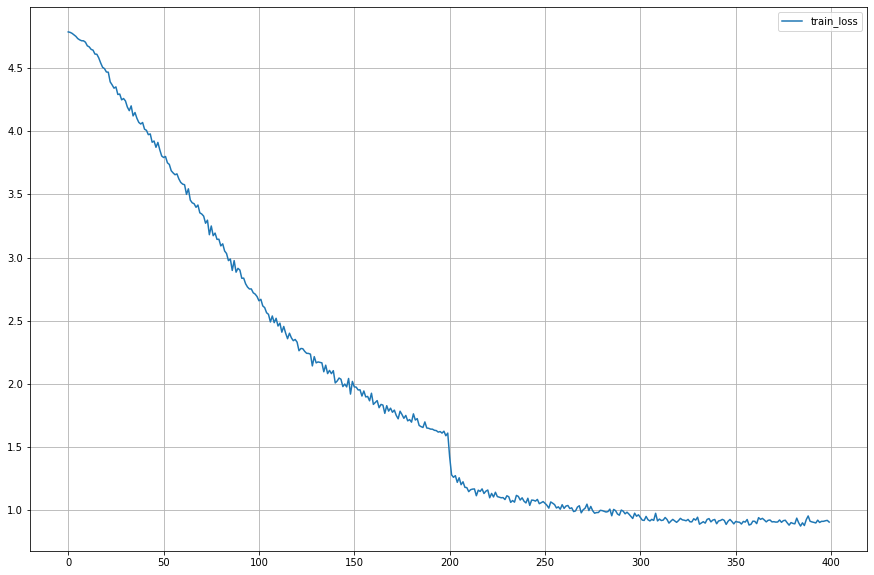

In [31]:
plt.figure(figsize = (15,10))
plt.plot(trn_loss_list, label="train_loss")
plt.legend()
plt.grid('on')
plt.show()